In [74]:
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using IterativeSolvers
using NearestNeighbors
using LinearAlgebra
using DoubleFloats
using Profile

In [89]:
function compile_kernel_array_NS(M)
    @variables x₁ x₂ ϵ u1 v1 u2 v2;
    N1 = size(M)[1]
    N2 = size(M)[2]
    P = Matrix{Function}(undef,N1,N2)
    for i = 1:N1
        for j = 1:N2
            #display(M[i,j])
            P[i,j] = eval(build_function(M[i,j], [x₁, x₂], [u1 v1 u2 v2],ϵ))
        end
    end
    return P
end
function compile_polynomials_NS(M)
    @variables x₁ x₂ ϵ u1 v1;
    N1 = size(M)[1]
    N2 = size(M)[2]
    P = Matrix{Function}(undef,N1,N2)
    for i = 1:N1
        for j = 1:N2
            #display(M[i,j])
            P[i,j] = eval(build_function(M[i,j], [x₁, x₂],[u1,v1]))
        end
    end
    return P
end
μ = 0.0025
ρ = 1.0
@variables ϵ r x₁ x₂ u1 v1 u2 v2 ;
ϕ1 = r^7
ϕ2 = r^3

ϕ1 = substitute(ϕ1, r=>sqrt(x₁^2 + x₂^2))
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2))

∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))

Δ(exprs) = ∂₁(∂₁(exprs)) + ∂₂(∂₂(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ1)) ∂₁(∂₂(ϕ1)) 0; ∂₁(∂₂(ϕ1)) -∂₁(∂₁(ϕ1)) 0; 0 0 ϕ2])

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ1x(x) =  -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])  #+  u1*∂₁(x[1]) + v1*∂₂(x[1])
λ2x(x) =  -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3]) #+ u1*∂₁(x[2]) + v1*∂₂(x[2])
λ3x(x) = x[1]
λ4x(x) = x[2]

λ1y(x) =  -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3]) #- u2*∂₁(x[1]) - v2*∂₂(x[1])
λ2y(x) =  -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3]) #-u2*∂₁(x[2]) - v2*∂₂(x[2])
λ3y(x) = x[1]
λ4y(x) = x[2]

display(Φ_div)

F_A = construct_kernel_array(Φ_div,[λu,λv,λ1x,λ2x,λ3x,λ4x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
display(F_A)
F_A = compile_kernel_array_NS(F_A)
F_B = construct_kernel_array(Φ_div,[λ1x,λ2x],[λu,λv,λ1y,λ2y,λ3y,λ4y])
display(F_B)
F_B = compile_kernel_array_NS(F_B)

P_list2D = generate_2D2_div_free_poly_basis(4)
P_list1D = generate_2D1_poly_basis(2)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
#display(P_list)

F_PA = apply_functionals_to_polynomials([λu,λv,λ1x,λ2x,λ3x,λ4x],P_list)
display(F_PA)
F_PA = compile_polynomials_NS(F_PA)

F_PB = apply_functionals_to_polynomials([λ1x,λ2x],P_list)
display(F_PB)
F_PB = compile_polynomials_NS(F_PB)

N_poly = size(F_PA)[2]

println("done")
F_A

3×3 Matrix{Num}:
 (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)  …                    0
                                  (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                       0
                                                                    0     sqrt(x₁^2 + x₂^2)^3

6×6 Matrix{Num}:
 (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)                                                                                                                                                                               …                                   (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)
                                  (35//1)*x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                                                                                                                                                                                  (-7//1)*(sqrt(x₁^2 + x₂^2)^5) - (35//1)*(x₁^2)*(sqrt(x₁^2 + x₂^2)^3)
                                                                    0.35(sqrt(x₁^2 + x₂^2)^3) + 0.2625(x₂^4)*(sqrt(x₁^2 + x₂^2)^-1) + 0.2625(x₁^2)*sqrt(x₁^2 + x₂^2) + 1.8375(x₂^2)*sqrt(x₁^2 + x₂^2) + 0.2625(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)                                                                       -0.2625x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1

2×6 Matrix{Num}:
  0.35(sqrt(x₁^2 + x₂^2)^3) + 0.2625(x₂^4)*(sqrt(x₁^2 + x₂^2)^-1) + 0.2625(x₁^2)*sqrt(x₁^2 + x₂^2) + 1.8375(x₂^2)*sqrt(x₁^2 + x₂^2) + 0.2625(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)  …  -0.2625x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1) - 1.575x₁*x₂*sqrt(x₁^2 + x₂^2) - 0.2625x₂*(x₁^3)*(sqrt(x₁^2 + x₂^2)^-1)
 -0.2625x₁*(x₂^3)*(sqrt(x₁^2 + x₂^2)^-1) - 1.575x₁*x₂*sqrt(x₁^2 + x₂^2) - 0.2625x₂*(x₁^3)*(sqrt(x₁^2 + x₂^2)^-1)                                                                      0.35(sqrt(x₁^2 + x₂^2)^3) + 0.2625(x₁^4)*(sqrt(x₁^2 + x₂^2)^-1) + 0.2625(x₂^2)*sqrt(x₁^2 + x₂^2) + 1.8375(x₁^2)*sqrt(x₁^2 + x₂^2) + 0.2625(x₁^2)*(x₂^2)*(sqrt(x₁^2 + x₂^2)^-1)

6×25 Matrix{Num}:
 1    x₂     x₁    x₂^2      …  0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0       0.0  0.0    0.0   0.0    0.0
 0.0   0.0    0.0    -0.005     0.0  1.0    0.0  x₂    2x₁
 0.0   0.0    0.0     0.0       1.0  0.0  2x₂    x₁      0.0
 1    x₂     x₁    x₂^2         0.0  0.0    0.0   0.0    0.0
 0.0   0.0  -x₂       0.0    …  0.0  0.0    0.0   0.0    0.0

2×25 Matrix{Num}:
 0.0  0.0  0.0  -0.005  0.0     -0.005  …  0.0  1.0    0.0  x₂  2x₁
 0.0  0.0  0.0   0.0    0.0025   0.0       1.0  0.0  2x₂    x₁    0.0

done


6×6 Matrix{Function}:
 #3035  #3037  #3039  #3041  #3043  #3045
 #3047  #3049  #3051  #3053  #3055  #3057
 #3059  #3061  #3063  #3065  #3067  #3069
 #3071  #3073  #3075  #3077  #3079  #3081
 #3083  #3085  #3087  #3089  #3091  #3093
 #3095  #3097  #3099  #3101  #3103  #3105

[0.0, 0.0]
[0.0, 1.0]
[1.0, 0.0]
[1.0, 1.0]


2×152 Matrix{Float64}:
 0.0       0.0        0.0        0.0       …  1.0       1.0       1.0
 0.025641  0.0512821  0.0769231  0.102564     0.923077  0.948718  0.974359

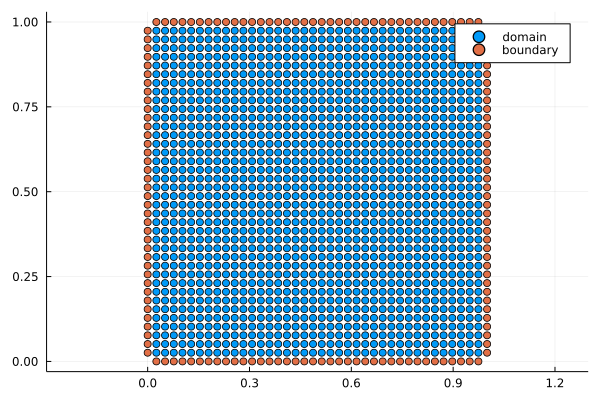

In [90]:
#generate points for lid_driven_cavity
N_side = 40
I_points, B_points = generate_2D_equally_spaced_points(N_side)
N_I = size(I_points)[2]
N_B = size(B_points)[2]
N_tot = N_I + N_B 
#all_points = [domain_p boundary_p]
println(B_points[:,1])
println(B_points[:,N_side])
println(B_points[:,3*N_side-3])
println(B_points[:,4*N_side-4])
B_points = B_points[:, setdiff(1:end,[1,N_side,4*N_side-4,3*N_side-3])]
display(B_points)
scatter(I_points[1,:],I_points[2,:],label="domain",aspect_ratio = :equal)
scatter!(B_points[1,:],B_points[2,:],label="boundary")

In [91]:
f1(x,y) = 0.0
f2(x,y) = 0.0

function gu(x,y)
    if abs(y-1) < 1e-10 #&& abs(x) > 1e-10 && abs(x-1) > 1e-10
        return 1#-(0.5-x)^2 + 0.25
    else
        return 0.0
    end
end
gv(x,y) = 0.0
gu(0.9,1)

1

In [94]:
# assemble matrices and rhs 

function apply_NS(p1,p2,u1,v1,u2,v2,f,param)
    d1 = size(p1)[2]
    d2 = size(p2)[2]
    M = zeros(d1,d2)
    if (d1 != length(u1)) || (d1 !=length(v1)) || (d2 != length(u2)) || (d2 !=length(v2))
        error("velocity and point arrays have  different sizes ")
    end
    for i in 1:d1
        for j in 1:d2
            a = p1[:,i]-p2[:,j]
            
            a = (abs.(a) .< [1e-60,1e-60])*1e-60 .+ a
            #println(a)
            M[i,j] = f(a,[u1[i] v1[i] u2[j] v2[j]],ϵ)
        end
    end
    return M
end

function apply_P_NS(p,u,v,fp_array)
    d1 = size(p)[2]
    d2 = length(fp_array)
    if (d1 != length(u)) || (d1 !=length(v))
        error("velocity and point arrays have  different sizes ")
    end
    res = zeros(d1,d2)
    for i in 1:d1
        for j in 1:d2
            res[i,j] = fp_array[j](p[:,i],[u[i],v[i]])
        end
    end
    return res
end


U = zeros(2*N_I)

function solve_linearized_NS(B_points,F_A,F_B,F_PA,F_PB,I_points,U,f1,f2,gu,gv,param)
    #B_points,F_A,F_B,F_PA,F_PB,I_points,U,f1,f2,gu,gv,param = collect(values(dictionary))
    N_I = size(I_points)[2]
    N_B = size(B_points)[2]
    N_poly = size(F_PA)[2]
    #display((; dictionary...))
    #param = 5
    k = 25
    r = 4.01*1.45/(N_side-1)
    I_tree = KDTree(I_points,Euclidean(),leafsize = 3)
    B_tree = KDTree(B_points,Euclidean(),leafsize = 3)
    G = zeros(2*N_I,2*N_I) # global sprse matrix 
    #Global_RHS = zeros(2*N_I)
    Global_RHS = vcat(f1.(I_points[1,:],I_points[2,:]),f2.(I_points[1,:],I_points[2,:]))
    cond_num_array = zeros(N_I)
    for i in 1:N_I
        #I_idx = inrange(I_tree, I_points[:,i], r, true)
        I_idx, _ = knn(I_tree, I_points[:,i], k, true)
        I_idx = deleteat!(I_idx,findall(x->x==i,I_idx))
        B_idx = inrange(B_tree, I_points[:,i], r, true)
        Local_B_points = B_points[:,B_idx] .- reshape(I_points[:,i],(2,1))
        Local_I_points = I_points[:,I_idx] .- reshape(I_points[:,i],(2,1))
        #display(Local_I_points)
        Full_Local_I_points = hcat(I_points[:,i],I_points[:,I_idx]) .- reshape(I_points[:,i],(2,1))# internal points including center 
        N_I_local = length(I_idx)+1 # total number of local points 
        #display(Full_Local_I_points)
        default_point_list = [Full_Local_I_points,Full_Local_I_points,Local_I_points,Local_I_points] # list of points if no boundary is present
        sample_point_list = [reshape([0.0,0.0],(2,1)),reshape([0.0,0.0],(2,1))]
        u_loc_full =  vcat(U[i],U[I_idx])
        v_loc_full =  vcat(U[i+N_I],U[I_idx .+ N_I])
        u_loc      =  U[I_idx]
        v_loc      =  U[I_idx .+ N_I]

        A11 = apply_NS(Full_Local_I_points,Full_Local_I_points,u_loc_full,v_loc_full,u_loc_full,v_loc_full,F_A[1,1],param)
        A12 = apply_NS(Full_Local_I_points,Full_Local_I_points,u_loc_full,v_loc_full,u_loc_full,v_loc_full,F_A[1,2],param)
        A13 = apply_NS(Full_Local_I_points,Local_I_points,u_loc_full,v_loc_full,u_loc,v_loc,F_A[1,3],param)
        A14 = apply_NS(Full_Local_I_points,Local_I_points,u_loc_full,v_loc_full,u_loc,v_loc,F_A[1,4],param)

        A22 = apply_NS(Full_Local_I_points,Full_Local_I_points,u_loc_full,v_loc_full,u_loc_full,v_loc_full,F_A[2,2],param)
        A23 = apply_NS(Full_Local_I_points,Local_I_points,u_loc_full,v_loc_full,u_loc,v_loc,F_A[2,3],param)
        A24 = apply_NS(Full_Local_I_points,Local_I_points,u_loc_full,v_loc_full,u_loc,v_loc,F_A[2,4],param)

        A33 = apply_NS(Local_I_points,Local_I_points,u_loc,v_loc,u_loc,v_loc,F_A[3,3],param)
        A34 = apply_NS(Local_I_points,Local_I_points,u_loc,v_loc,u_loc,v_loc,F_A[3,4],param)

        A44 = apply_NS(Local_I_points,Local_I_points,u_loc,v_loc,u_loc,v_loc,F_A[4,4],param)

        P1 = apply_P_NS(Full_Local_I_points,u_loc_full,v_loc_full,F_PA[1,:])
        P2 = apply_P_NS(Full_Local_I_points,u_loc_full,v_loc_full,F_PA[2,:])
        P3 = apply_P_NS(Local_I_points,u_loc,v_loc,F_PA[3,:])
        P4 = apply_P_NS(Local_I_points,u_loc,v_loc,F_PA[4,:])

        PB1 = apply_P_NS(reshape([0.0,0.0],(2,1)),[U[i]],[U[i+N_I]],F_PB[1,:])
        PB2 = apply_P_NS(reshape([0.0,0.0],(2,1)),[U[i]],[U[i+N_I]],F_PB[2,:])
        B11 = apply_NS(reshape([0.0,0.0],(2,1)),Full_Local_I_points,[U[i]],U[i+N_I],u_loc_full,v_loc_full,F_B[1,1],param)
        B12 = apply_NS(reshape([0.0,0.0],(2,1)),Full_Local_I_points,[U[i]],U[i+N_I],u_loc_full,v_loc_full,F_B[1,2],param)

        B13 = apply_NS(reshape([0.0,0.0],(2,1)),Local_I_points,[U[i]],U[i+N_I],u_loc,v_loc,F_B[1,3],param)
        B14 = apply_NS(reshape([0.0,0.0],(2,1)),Local_I_points,[U[i]],U[i+N_I],u_loc,v_loc,F_B[1,4],param)

        B21 = apply_NS(reshape([0.0,0.0],(2,1)),Full_Local_I_points,[U[i]],U[i+N_I],u_loc_full,v_loc_full,F_B[2,1],param)
        B22 = apply_NS(reshape([0.0,0.0],(2,1)),Full_Local_I_points,[U[i]],U[i+N_I],u_loc_full,v_loc_full,F_B[2,2],param)
        B23 = apply_NS(reshape([0.0,0.0],(2,1)),Local_I_points,[U[i]],U[i+N_I],u_loc,v_loc,F_B[2,3],param)
        B24 = apply_NS(reshape([0.0,0.0],(2,1)),Local_I_points,[U[i]],U[i+N_I],u_loc,v_loc,F_B[2,4],param)

        #display(B11)
        #L_RHS = zeros(2*N_I_local-2)
        L_RHS = vcat(f1.(I_points[1,I_idx],I_points[2,I_idx]),f2.(I_points[1,I_idx],I_points[2,I_idx]))
        if isempty(B_idx)

            #println(size(A11))
            #println(size(P1))
            RHS = vcat(L_RHS,zeros(N_poly))
            A = [A11 A12 A13 A14 P1;
            A12' A22 A23 A24 P2;
            A13' A23' A33 A34 P3;
            A14' A24' A34' A44 P4;
            P1' P2' P3' P4' zeros(N_poly,N_poly)]
            #display(cond(A))
            B = [B11 B12 B13 B14 PB1;
                B21 B22 B23 B24 PB2]

        else
            # present bc
            #RHS = vcat(L_RHS,true_v1.(B_points[1,B_idx],B_points[2,B_idx]),true_v2.(B_points[1,B_idx],B_points[2,B_idx])
            #,zeros(N_poly))
            RHS = vcat(L_RHS,gu.(B_points[1,B_idx],B_points[2,B_idx]),gv.(B_points[1,B_idx],B_points[2,B_idx])
            ,zeros(N_poly))
            #display(RHS[length(L_RHS)+1:end-N_poly])
            zero_u = zeros(length(B_idx))
            A15 = apply_NS(Full_Local_I_points,Local_B_points,u_loc_full,v_loc_full,zero_u,zero_u,F_A[1,5],param)
            A16 = apply_NS(Full_Local_I_points,Local_B_points,u_loc_full,v_loc_full,zero_u,zero_u,F_A[1,6],param)
            A25 = apply_NS(Full_Local_I_points,Local_B_points,u_loc_full,v_loc_full,zero_u,zero_u,F_A[2,5],param)
            A26 = apply_NS(Full_Local_I_points,Local_B_points,u_loc_full,v_loc_full,zero_u,zero_u,F_A[2,6],param)

            A35 = apply_NS(Local_I_points,Local_B_points,u_loc,v_loc,zero_u,zero_u,F_A[3,5],param)
            A36 = apply_NS(Local_I_points,Local_B_points,u_loc,v_loc,zero_u,zero_u,F_A[3,6],param)
            A45 = apply_NS(Local_I_points,Local_B_points,u_loc,v_loc,zero_u,zero_u,F_A[4,5],param)
            A46 = apply_NS(Local_I_points,Local_B_points,u_loc,v_loc,zero_u,zero_u,F_A[4,6],param)

            A55 = apply_NS(Local_B_points,Local_B_points,zero_u,zero_u,zero_u,zero_u,F_A[5,5],param)
            A56 = apply_NS(Local_B_points,Local_B_points,zero_u,zero_u,zero_u,zero_u,F_A[5,6],param)
            A66 = apply_NS(Local_B_points,Local_B_points,zero_u,zero_u,zero_u,zero_u,F_A[6,6],param)

            P5 = apply_P_NS(Local_B_points,zero_u,zero_u,F_PA[5,:])
            P6 = apply_P_NS(Local_B_points,zero_u,zero_u,F_PA[6,:])

            B15 = apply_NS(reshape([0.0,0.0],(2,1)),Local_B_points,[U[i]],U[i+N_I],zero_u,zero_u,F_B[1,5],param)
            B16 = apply_NS(reshape([0.0,0.0],(2,1)),Local_B_points,[U[i]],U[i+N_I],zero_u,zero_u,F_B[1,6],param)
            B25 = apply_NS(reshape([0.0,0.0],(2,1)),Local_B_points,[U[i]],U[i+N_I],zero_u,zero_u,F_B[2,5],param)
            B26 = apply_NS(reshape([0.0,0.0],(2,1)),Local_B_points,[U[i]],U[i+N_I],zero_u,zero_u,F_B[2,6],param)

            A = [A11 A12  A13  A14  A15  A16 P1;
                A12' A22  A23  A24  A25  A26 P2;
                A13' A23' A33  A34  A35  A36 P3;
                A14' A24' A34' A44  A45  A46 P4;
                A15' A25' A35' A45' A55  A56 P5;
                A16' A26' A36' A46' A56' A66 P6;
                P1' P2' P3' P4' P5' P6' zeros(N_poly,N_poly)]
            #println(cond(A))
            B = [B11 B12 B13 B14 B15 B16 PB1;
                B21 B22 B23 B24  B25 B26 PB2]
        end
        
        cond_num_array[i] = cond(A)
        N_I_local = length(I_idx)+1
        C = B*inv(A)
        G[[i,N_I+i],vcat([i],I_idx,[i+N_I], I_idx .+ N_I)] .= C[:,1:2*N_I_local]
        Global_RHS[[i,N_I+i]] .+= -(C[:,1+2*N_I_local:end] * RHS) 

    end
    G_s = sparse(G)
    sol = G_s\Global_RHS
    println("max local cond number: ",maximum(cond_num_array))
    #println("min local cond number: ",minimum(cond_num_array))
    return sol
end
sol = solve_linearized_NS(B_points,F_A,F_B,F_PA,F_PB,I_points,U,f1,f2,gu,gv,5)
print("done")

max local cond number: 2.007194387355983e9
done

In [78]:
N_cycles = 10
U = zeros(2*N_I)
U_list = [U]
err_list = []
for i in 1:10
    U = solve_linearized_NS(B_points,F_A,F_B,F_PA,F_PB,I_points,U,f1,f2,gu,gv,5)
    append!(U_list,[U])
    err = sum(abs.(U_list[i+1]-U_list[i]))
    append!(err_list,[err])
end
sol=U


max local cond number: 7.124049291683114e7
max local cond number: 8.007130795841125e7
max local cond number: 7.134575167620002e7
max local cond number: 7.820883990985924e7
max local cond number: 5.753576427333526e9
max local cond number: 7.122115864965004e7
max local cond number: 2.6815593462914178e8
max local cond number: 8.075267154626152e7
max local cond number: 9.440723651732568e7
max local cond number: 7.839605809730899e9


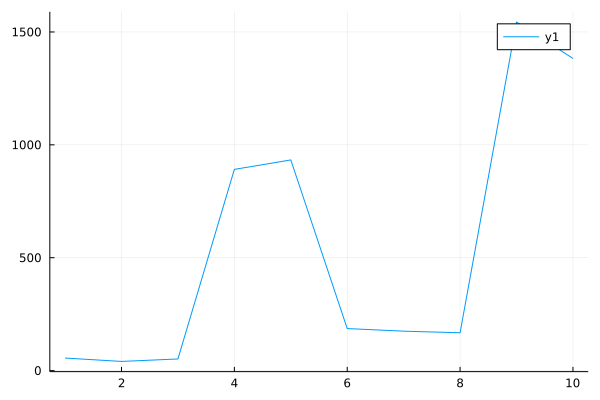

In [81]:
plot(1:10,abs.(err_list))

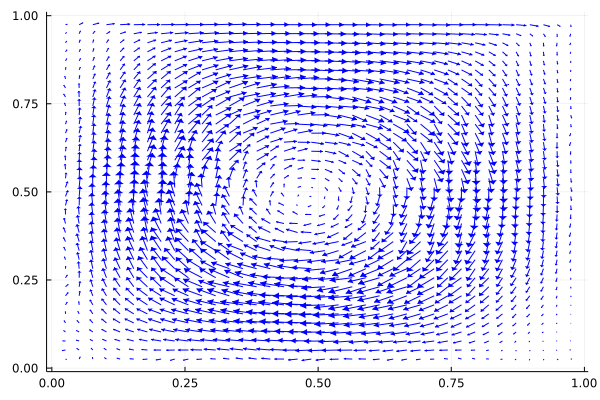

In [95]:
function plot_arrow!(x1,y1,x2,y2)
    color = :blue
    arr_width = 0.2
    vx = x2-x1
    vy = y2 -y1
    l_arr = sqrt(vx*vx+vy*vy)
    pqx= x1+3*(x2-x1)/4
    pqy= y1+3*(y2-y1)/4 # quarterpoint

    vpx = 1
    vpy = -vx/vy
    lp = sqrt(vpx*vpx + vpy*vpy)
    vpx = vpx/lp
    vpy = vpy/lp 

    p1ax = pqx + vpx*l_arr*arr_width
    p1ay = pqy + vpy*l_arr*arr_width

    p2ax = pqx - vpx*l_arr*arr_width
    p2ay = pqy - vpy*l_arr*arr_width

    plot!([x1,x2],[y1,y2],c=color,label = false) # line
    trian = Shape([(p1ax, p1ay),(p2ax,p2ay), (x2,y2), (p1ax, p1ay)])
    plot!(trian, c = color,label = false,linewidth = 0)
end

function visualize_vec_field(Points,u,v)
    scale = 0.05
    vel = sqrt.(u.^2 .+ v .^2)
    mx = maximum(vel)
    #print(size(Points))
    plot()
    for i in 1:size(Points)[2]
        px,py = Points[:,i]
        #print(px,py)
        #plot!([px,px+scale*u[i]/mx],[py,py+scale*v[i]/mx],label = false,arrow = arrow(),)
        plot_arrow!(px,py,px+scale*u[i]/mx,py+scale*v[i]/mx)
    end
    plot!()
end


visualize_vec_field(I_points,sol[1:N_I],sol[1+N_I:end])